In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import os
import re
import shutil
import string

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Review_dataset/data.csv'

Mounted at /content/drive


In [4]:
data = pd.read_csv(path)

In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
data.shape

(50000, 2)

In [8]:
data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [9]:
data['review'] = data['review'].drop_duplicates()

In [10]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<Axes: >

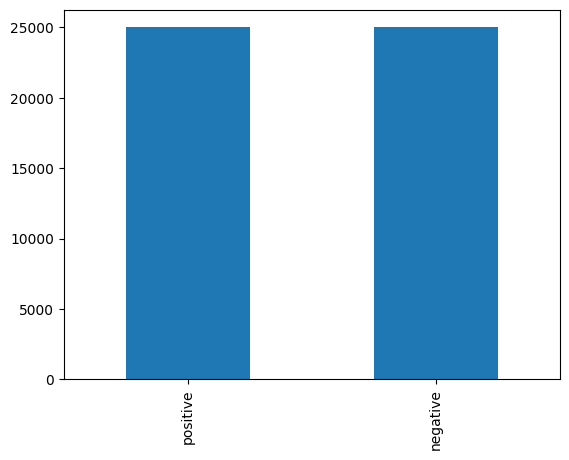

In [11]:
data['sentiment'].value_counts().plot(kind='bar')

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return text

In [13]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [14]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
data['review'] = data['review'].apply(clean_text)

In [16]:
data['review'] = data['review'].apply(remove_emoji)

In [17]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

le = preprocessing.LabelEncoder()
data['sentiment'] = le.fit_transform(data.sentiment.values)

In [18]:
data.head(10)

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,a wonderful little production br br the filmin...,1
2,i thought wonderful way spend time hot summer ...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
5,probably alltime favorite movie story selfless...,1
6,i sure would like see resurrection dated seahu...,1
7,this show amazing fresh innovative idea 70s f...,0
8,encouraged positive comments film i looking fo...,0
9,if like original gut wrenching laughter like m...,1


In [19]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
data['review'] = data['review'].apply(lemmatize_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [20]:
data.head(10)

,review,sentiment
0,one reviewers mention watch 1 oz episode hook ...,1
1,a wonderful little production br br the film t...,1
2,i think wonderful way spend time hot summer we...,1
3,basically theres family little boy jake think ...,0
4,petter matteis love time money visually stun f...,1
5,probably alltime favorite movie story selfless...,1
6,i sure would like see resurrection date seahun...,1
7,this show amaze fresh innovative idea 70s firs...,0
8,encourage positive comment film i look forward...,0
9,if like original gut wrench laughter like movi...,1


In [21]:
X = data['review']
y = data['sentiment']

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [26]:
max_length = 500  # Set the desired sequence length

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [27]:
embedding_dim = 100  # Set the desired embedding dimension

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
epochs = 10  # Set the desired number of training epochs

model.fit(X_train_pad, y_train, epochs=epochs, validation_data=(X_test_pad, y_test))

Epoch 1/10
1250/1250 [==============================] - 190s 146ms/step - loss: 0.6933 - accuracy: 0.4976 - val_loss: 0.6934 - val_accuracy: 0.4965
Epoch 2/10
1250/1250 [==============================] - 69s 55ms/step - loss: 0.6928 - accuracy: 0.5005 - val_loss: 0.6934 - val_accuracy: 0.5041
Epoch 3/10
1250/1250 [==============================] - 45s 36ms/step - loss: 0.6912 - accuracy: 0.5015 - val_loss: 0.6947 - val_accuracy: 0.4965
Epoch 4/10
1250/1250 [==============================] - 42s 34ms/step - loss: 0.6875 - accuracy: 0.5091 - val_loss: 0.6995 - val_accuracy: 0.5046
Epoch 5/10
1250/1250 [==============================] - 38s 31ms/step - loss: 0.6857 - accuracy: 0.5045 - val_loss: 0.6983 - val_accuracy: 0.4978
Epoch 6/10
1250/1250 [==============================] - 35s 28ms/step - loss: 0.6852 - accuracy: 0.5085 - val_loss: 0.6978 - val_accuracy: 0.5047
Epoch 7/10
1250/1250 [==============================] - 37s 30ms/step - loss: 0.6848 - accuracy: 0.5069 - val_loss: 0.6972

In [31]:
y_pred = model.predict(X_test_pad)

313/313 [==============================] - 4s 8ms/step


In [36]:
threshold = 0.5
y_pred_binary = [1 if val > threshold else 0 for val in y_pred]

In [37]:
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.498


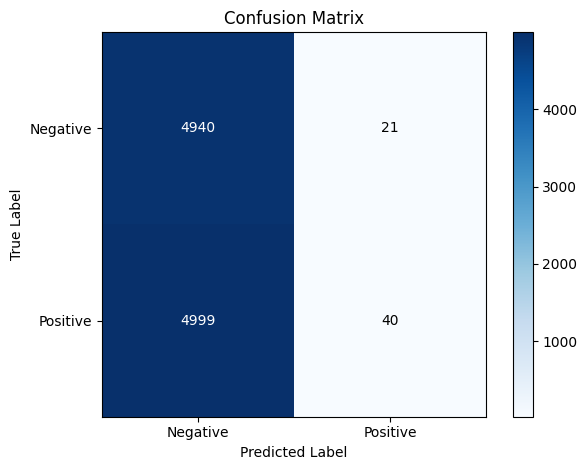

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_binary)

class_labels = ['Negative', 'Positive']

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_labels, yticklabels=class_labels,
       title='Confusion Matrix',
       ylabel='True Label',
       xlabel='Predicted Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

In [39]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.2 MB/s eta 0:00:00


In [41]:
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

In [42]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  # Specify the BERT model variant
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
data.head()

,review,sentiment
0,one reviewers mention watch 1 oz episode hook ...,1
1,a wonderful little production br br the film t...,1
2,i think wonderful way spend time hot summer we...,1
3,basically theres family little boy jake think ...,0
4,petter matteis love time money visually stun f...,1


In [50]:
# Preprocess the text data
X = data['review']  # Input text data
y = data['sentiment']  # Target variable

# Tokenize the input text
encoded_inputs = tokenizer.batch_encode_plus(
    X,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# Convert the tokenized inputs to TensorFlow tensors
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']
labels = tf.convert_to_tensor(y)

In [59]:
input_ids = np.array(input_ids)
labels = np.array(labels)

In [60]:
from sklearn.model_selection import train_test_split

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids,
    labels,
    test_size=0.2,
    random_state=42
)

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [65]:
epoch = 3
history = model.fit(train_inputs, train_labels, epochs=epoch, batch_size=32, verbose=1)

# Print the accuracy and loss for each epoch
for epoch in range(epoch):
    print("Epoch:", epoch+1)
    print("Accuracy:", history.history['accuracy'][epoch])
    print("Loss:", history.history['loss'][epoch])
    print()

Epoch 1/3
1250/1250 [==============================] - 1190s 911ms/step - loss: 0.3473 - accuracy: 0.8368
Epoch 2/3
1250/1250 [==============================] - 1137s 909ms/step - loss: 0.2099 - accuracy: 0.9179
Epoch 3/3
1250/1250 [==============================] - 1137s 909ms/step - loss: 0.1221 - accuracy: 0.9555
Epoch: 1
Accuracy: 0.8368499875068665
Loss: 0.3472795784473419

Epoch: 2
Accuracy: 0.9178500175476074
Loss: 0.2099023163318634

Epoch: 3
Accuracy: 0.9555249810218811
Loss: 0.12207522243261337



In [66]:
# Evaluate the model
results = model.evaluate(test_inputs, test_labels)
print("Accuracy:", results[1])

313/313 [==============================] - 99s 306ms/step - loss: 0.3008 - accuracy: 0.8928
Accuracy: 0.892799973487854
